<a href="https://colab.research.google.com/github/ceren-turan/DSA210-Project/blob/main/main_with_additional_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********             18%                       ]  3 of 17 completed

Scraped 17 tickers.


[*********************100%***********************]  16 of 17 completed
ERROR:yfinance:
3 Failed downloads:
[*********************100%***********************]  16 of 17 completedERROR:yfinance:['TRADE-USD', 'SUI-USD', 'LCS-USD']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-04-23 -> 2025-04-27)')


Fetched returns for 17 tickers.


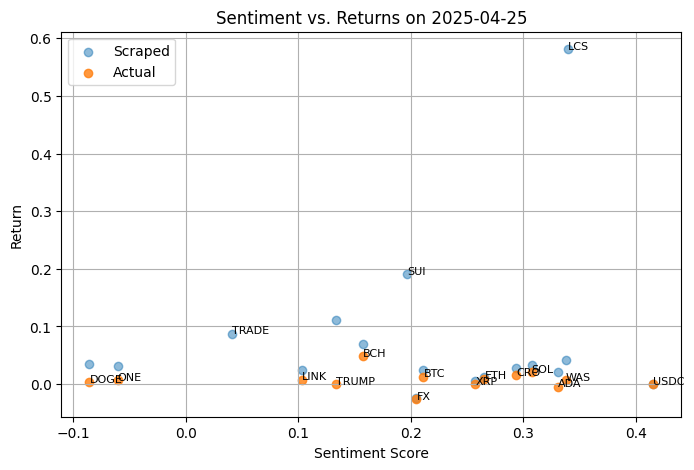

Pearson correlation: r = -0.024, p-value = 0.847
→ p ≥ 0.05: cannot reject H₀, no significant correlation.

=== Descriptive Statistics ===
       sentiment_score  ActualReturn
count        89.000000     70.000000
mean          0.217668      0.003895
std           0.148946      0.015417
min          -0.085519     -0.026288
25%           0.133251     -0.003284
50%           0.212563      0.001255
75%           0.331153      0.009328
max           0.487354      0.048881

=== Missing Values ===
ticker              0
sentiment_score     0
ActualReturn       19
date                0
dtype: int64


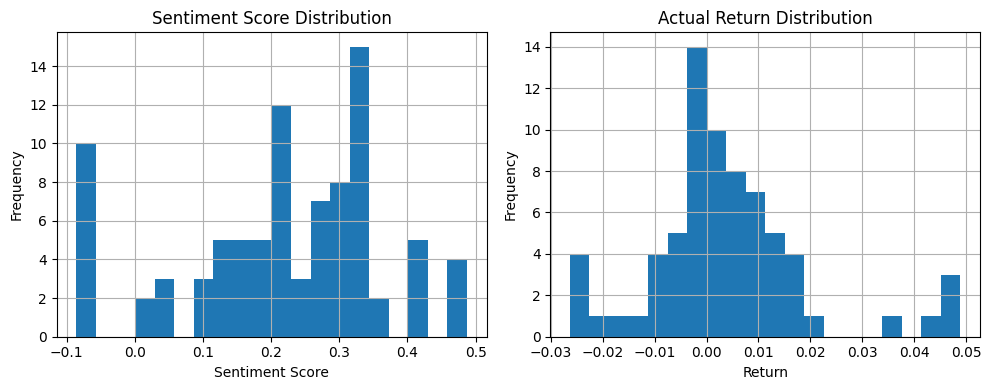

<ipython-input-5-cebc56c300f5>:134: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df['sentiment_score'].dropna(), df['ActualReturn'].dropna()], labels=['Sentiment','Return'])


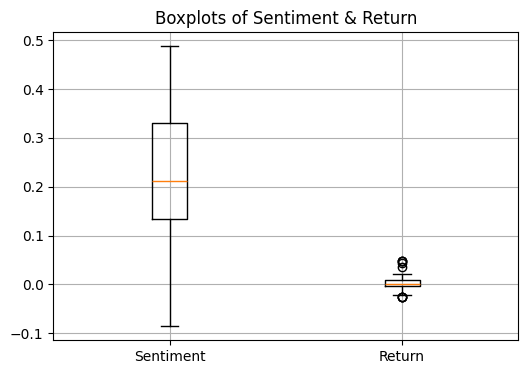

In [5]:
import os
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime, timedelta
import traceback
from scipy.stats import pearsonr


# Scrape Reddit sentiment score of cryptocurrencies for a single day

def scrape_reddit_mentions(url):
    headers = {"User-Agent": "Mozilla/5.0"}

    r = requests.get(url, headers=headers)
    r.raise_for_status()
    soup = BeautifulSoup(r.content, 'html.parser')
    rows = []
    for tr in soup.find_all("tr"):
        cols = [td.get("data-value", td.get_text(strip=True)).strip() for td in tr.find_all("td")]
        if cols and len(cols) >= 8 and cols[2] == "crypto":
            rows.append(cols)

    df = pd.DataFrame(rows, columns=['rank','ticker','category','name','mentions','mentions_change_pct','sentiment_score','price_change'])
    df = df[['ticker','sentiment_score','price_change']]
    df['sentiment_score'] = pd.to_numeric(df['sentiment_score'], errors='coerce')
    df['price_change']     = pd.to_numeric(df['price_change'], errors='coerce')
    df.dropna(subset=['sentiment_score','price_change'], inplace=True)
    return df


# Fetch actual price data from Yahoo Finance and calculate returns

def fetch_next_day_returns(tickers, sentiment_date):
    records = []
    start = sentiment_date - timedelta(days=1)
    end   = sentiment_date + timedelta(days=3)

    yf_syms = [t + '-USD' for t in tickers]
    raw = yf.download(tickers=yf_syms, start=start.isoformat(), end=end.isoformat(),
                     group_by='ticker', auto_adjust=False, threads=True)
    multi = hasattr(raw.columns, 'levels')
    for t, sym in zip(tickers, yf_syms):
        df_sym = (raw[sym] if multi else raw).reset_index()[['Date','Close']]
        df_sym['Date'] = df_sym['Date'].dt.date
        df_sym = df_sym[df_sym['Date'] >= sentiment_date].sort_values('Date').head(2)
        if len(df_sym) < 2:
            continue
        p0, p1 = df_sym['Close'].iloc[0], df_sym['Close'].iloc[1]
        records.append({'ticker': t, 'ActualReturn': (p1-p0)/p0})

    return pd.DataFrame(records)


# Append daily findings to the longitudinal dataset

def save_daily_results(sent_df, ret_df, sentiment_date, csv_path='daily_crypto_sentiment.csv'):
    df = sent_df.merge(ret_df, on='ticker', how='left')
    df = df.rename(columns={'price_change':'chart_price_change'})
    df = df[['ticker','sentiment_score','ActualReturn']].copy()
    df['date'] = sentiment_date
    header = not os.path.exists(csv_path)
    df.to_csv(csv_path, mode='a', index=False, header=header)


# Pearson hypothesis test on the accumulated data

def run_hypothesis_test(csv_path='daily_crypto_sentiment.csv', alpha=0.05):
    df = pd.read_csv(csv_path, parse_dates=['date']).dropna(subset=['ActualReturn'])

    r, pval = pearsonr(df['sentiment_score'], df['ActualReturn'])
    print(f"Pearson correlation: r = {r:.3f}, p-value = {pval:.3f}")
    if pval < alpha:
        print(f"→ p < {alpha}: reject H₀, significant correlation.")
    else:
        print(f"→ p ≥ {alpha}: cannot reject H₀, no significant correlation.")


# Plot scraped vs actual returns for single day

def plot_single_day(sent_df, ret_df):
    df = sent_df.merge(ret_df, on='ticker', how='left')
    plt.figure(figsize=(8,5))
    plt.scatter(df['sentiment_score'], df['price_change']/100, label='Scraped', alpha=0.5)
    actual = df.dropna(subset=['ActualReturn'])
    if not actual.empty:
        plt.scatter(actual['sentiment_score'], actual['ActualReturn'], label='Actual', alpha=0.8)
    plt.xlabel('Sentiment Score')
    plt.ylabel('Return')
    plt.title(f'Sentiment vs. Returns on {datetime.today().date()}')
    plt.legend(); plt.grid(True)
    for _,row in df.iterrows():
        y = row['ActualReturn'] if pd.notna(row['ActualReturn']) else row['price_change']/100
        plt.annotate(row['ticker'], (row['sentiment_score'], y), fontsize=8)
    plt.show()


# EDA Functions

def descriptive_summary(csv_path='daily_crypto_sentiment.csv'):
    df = pd.read_csv(csv_path, parse_dates=['date'])
    print("\n=== Descriptive Statistics ===")
    print(df[['sentiment_score','ActualReturn']].describe())
    return df


def plot_univariate_distributions(df):
    # Histograms
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.hist(df['sentiment_score'].dropna(), bins=20)
    plt.title('Sentiment Score Distribution')
    plt.xlabel('Sentiment Score')
    plt.ylabel('Frequency')
    plt.grid(True)

    plt.subplot(1,2,2)
    plt.hist(df['ActualReturn'].dropna(), bins=20)
    plt.title('Actual Return Distribution')
    plt.xlabel('Return')
    plt.ylabel('Frequency')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Boxplots
    plt.figure(figsize=(6,4))
    plt.boxplot([df['sentiment_score'].dropna(), df['ActualReturn'].dropna()], labels=['Sentiment','Return'])
    plt.title('Boxplots of Sentiment & Return')
    plt.grid(True)
    plt.show()

# Main execution
if __name__ == '__main__':
    url = "https://chartexchange.com/trends/reddit/mentions/cx-all/"
    sentiment_date = datetime.today().date() - timedelta(days=1)

    # Scrape & fetch
    sent_df = scrape_reddit_mentions(url)
    print(f"Scraped {len(sent_df)} tickers.")
    ret_df = fetch_next_day_returns(sent_df['ticker'].tolist(), sentiment_date)
    print(f"Fetched returns for {len(ret_df)} tickers.")

    # Save
    save_daily_results(sent_df, ret_df, sentiment_date)

    # Single-day plot & hypothesis test
    plot_single_day(sent_df, ret_df)
    run_hypothesis_test()

    # Additional EDA Steps
    df_long = descriptive_summary()
    plot_univariate_distributions(df_long)

